In [2]:
import tensorflow as tf
import keras
from keras import backend as bk
import timeit

from scipy.integrate import ode
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import random as rdm
import time
from datetime import datetime
import matplotlib.animation as animation

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Model

In [22]:
class custom_model:

    def __init__(self):
        xavier=tf.keras.initializers.GlorotUniform()
        self.l1=tf.keras.layers.Dense(2,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l2=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l3=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l4=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l5=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.out=tf.keras.layers.Dense(1,kernel_initializer=xavier)
        self.train_op = tf.keras.optimizers.Adam(learning_rate=0.01)

    # Running the model

    def run(self, X):
        #with tf.device('/cpu:0'):
        boom = self.l1(X)
        boom1 = self.l2(boom)
        boom2 = self.l3(boom1)
        boom3 = self.l4(boom2)
        boom4 = self.l5(boom3)
        boom5 = self.out(boom4)
        return boom5

    def get_loss(self, Xf, XuI, XuB, YI, YB):
    
        with tf.GradientTape() as tape:
            tape.watch(Xf)
            
            with tf.GradientTape() as tape1:
                tape1.watch(Xf)
                boom = self.l1(Xf)
                boom1 = self.l2(boom)
                boom2 = self.l3(boom1)
                boom3 = self.l4(boom2)
                boom4 = self.l5(boom3)
                boom5 = self.out(boom4)
                g = tape1.gradient(boom5, Xf)
            gg = tape.gradient(g, Xf)
    
        u_t = g[:, 0]
        u_x = g[:, 1]
        u_xx = gg[:, 1]
        u = boom5[:, 0]
        
        #print('u_t: ', u_t)
        #print('u_x: ', u_x)
        #print('u_xx: ', u_xx)
        #print('u: ', u)
        
        
        MSEf = tf.reduce_mean((u_t - u_xx)**2)
        
        
        Y_I_predict = self.run(XuI)
        Y_B_predict = self.run(XuB)
        MSEu =  tf.reduce_mean((Y_I_predict - YI)**2) + tf.reduce_mean((Y_B_predict - YB)**2)
        
        return MSEu + MSEf

    def get_grad(self, Xf, XuI, XuB, YI, YB):
        with tf.GradientTape() as tape:
            tape.watch(self.l1.variables)
            tape.watch(self.l2.variables)
            tape.watch(self.l3.variables)
            tape.watch(self.l4.variables)
            tape.watch(self.l5.variables)
            tape.watch(self.out.variables)
            L = self.get_loss(Xf, XuI, XuB, YI, YB)
            g = tape.gradient(L, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.l4.variables[0],self.l4.variables[1],self.l5.variables[0],self.l5.variables[1],self.out.variables[0],self.out.variables[1]])
        return g

    # perform gradient descent

    def network_learn(self, Xf, XuI, XuB, YI, YB):
        g = self.get_grad(Xf, XuI, XuB, YI, YB)
        self.train_op.apply_gradients(zip(g, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.l4.variables[0],self.l4.variables[1],self.l5.variables[0],self.l5.variables[1],self.out.variables[0],self.out.variables[1]]))


### Model

In [23]:
Model = custom_model()

### Training Set

In [24]:
N_initial = 1000
N_collocation = 10000
N_boundary = 1000

B_points = tf.constant([[rdm.randrange(0, 1000, 1)*0.001, rdm.randrange(0,4,3)] for i in range(N_boundary)])
I_points = tf.constant([[0 , rdm.randrange(0, 3001, 1)*0.001] for i in range(N_initial)])
C_points = tf.constant([[rdm.randrange(1, 1000, 1)*0.001, rdm.randrange(1, 3000, 1)*0.001] for i in range(N_collocation)])

### Plot The Training Set

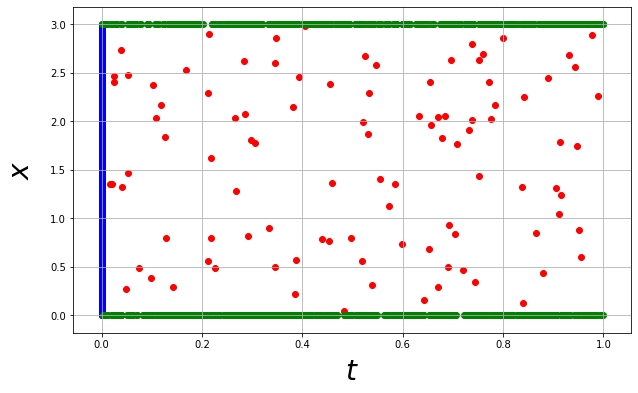

In [25]:
plt.figure(figsize=(10, 6))

plt.scatter(I_points[:,0], I_points[:,1], color='b')
plt.scatter(C_points[:100, 0], C_points[:100, 1], color='r')
plt.scatter(B_points[:, 0], B_points[:, 1], color='g')

plt.xlabel("$t$", fontsize=28, labelpad=8)
plt.ylabel("$x$", fontsize=28, labelpad=15)
plt.grid()
plt.show()

In [26]:
#Sin(x)^2
#YI = [[tf.math.sin(mt.pi*i[1])**2] for i in I_points]

def init(x):
    if x<1:
        return mt.sin(mt.pi*x)
    else:
        return 0
YI = [[init(i[1])] for i in I_points]
YB = tf.constant([[0.]])
#plt.figure(figsize=(8, 8))

### Plot Initial Conditions

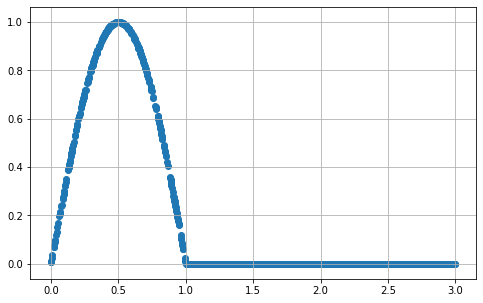

In [27]:
plt.figure(figsize=(8, 5))
plt.scatter(I_points[:,1], YI)
plt.grid()
plt.show()

### Training

In [28]:
start = timeit.default_timer()
epochs = 1000
Loss = []
for i in range(epochs):
    
    #re-sampling the training set
    B_points = tf.constant([[rdm.randrange(0, 1000, 1)*0.001, rdm.randrange(0,4,3)] for i in range(N_boundary)])
    I_points = tf.constant([[0 , rdm.randrange(0, 3001, 1)*0.001] for i in range(N_initial)])
    C_points = tf.constant([[rdm.randrange(1, 1000, 1)*0.001, rdm.randrange(1, 3000, 1)*0.001] for i in range(N_collocation)])
    YI = [[init(i[1])] for i in I_points]
    
    Model.network_learn(C_points, I_points, B_points, YI, YB)
    if i % 1 == 0:
        #print((i/10000)*100, '%')
        loss = Model.get_loss(C_points, I_points, B_points, YI, YB).numpy()
        Loss.append(loss)
        #print('Loss: ', Model.get_loss(C_points, I_points, B_points, YI, YB).numpy())
    if i%(epochs/5)==0:
        #print((i/epochs)*100, '%')
        print((i/epochs)*100, '%', end='\r')
    print
    

stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  513.102568


### Plot The Loss

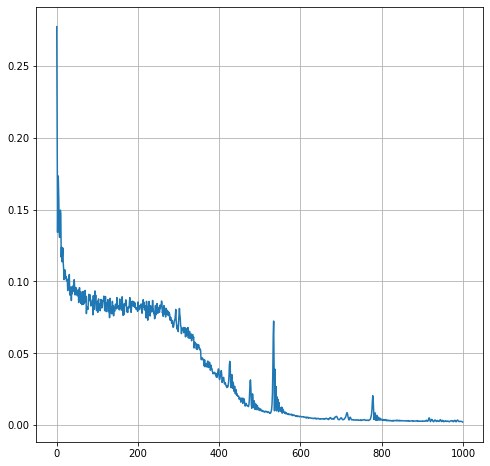

In [29]:
plt.figure(figsize=(8, 8))
plt.plot(Loss[0:1000])
plt.grid()
plt.show()

### Plot

In [62]:
start = timeit.default_timer()

#with tf.device('/cpu:0'):

H = []
for j in range(0, 100):
    h=[]
    for i in range(0, 100):
        h.append(Model.run(tf.constant([[i*0.01, j*0.01]]))[0][0])
    H.append(h)

stop = timeit.default_timer()
print('Time: ', stop - start)

x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)

z = np.array(H)

plt.figure(figsize=(8, 8))
plt.xlabel("$t$", fontsize=28, labelpad=8)
plt.ylabel("$x$", fontsize=28, labelpad=15)
plt.contourf(x,y,z)

KeyboardInterrupt: 

### Animated Plot

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


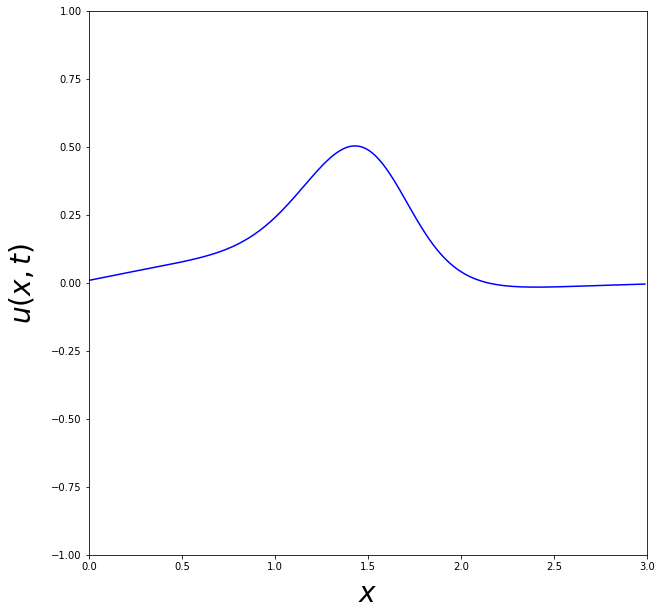

In [30]:
ims = []
fig = plt.figure(figsize=(10, 10))
x = [i*0.01 for i in range(0,300)]
T = [i*0.02 for i in range(0,50)]
for t in T:
    u = []
    for i in x:
        u.append(Model.run(tf.constant([[t, i]]))[:, 0].numpy())
    
    
    plt.ylim(-1, 1)
    plt.xlim(0,3)
    plt.xlabel("$x$", fontsize=28, labelpad=8)
    plt.ylabel("$u(x,t)$", fontsize=28, labelpad=15)
    plt.grid()
    #plt.plot(x, u)
    ims.append(plt.plot(x, u, color='b'))

#plt.show()

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
ani.save('Diffusion.gif')
plt.show()

In [93]:
Model.run(tf.constant([[0., 0.]]))**2

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.02664495]], dtype=float32)>